In [44]:
import math
import os
import pandas as pd
import numpy as np
from statistics import mean 
import random
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
import nltk
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, GRU, Dense, Embedding
from keras.utils import  pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from sklearn.model_selection import train_test_split

### Loading the Dataset
Here we load the data from the `dataset.csv` file (generated in the other script)

In [2]:
def load_data():
    return pd.read_csv('data/dataset.csv')

In [3]:
def load_vocabulary():
    vocabulary = list()
    with open('data/vocab-30k.txt', encoding='utf-8') as f:
        for line in f:
            vocabulary.append(line.strip())
    return vocabulary

### Data pre-processing
Transform to lower, remove the new line and the punctuation

In [4]:
def lower_data(data):
    return data.str.lower() 
    
def clean_data(data):
    return data.str.replace(',', ' , ')                \
                .str.replace('.',' . ', regex=False)  \
                .str.replace('?',' ? ', regex=False)   \
                .str.replace("''",' ', regex=False)   \
                .str.replace(r"(\s)'|'(\s)",' ', regex=True) \
                .str.replace(r"[^a-zA-Z0-9?'.,]+",' ',regex=True)

def get_data():
    data = load_data()
    for column in data.columns:    
        data[column] = lower_data(data[column])
        data[column] = clean_data(data[column])
    return shuffle(data)

### Data analysis
Mean sentence length and standard deviation of sentence length

In [5]:
def print_data_analysis(clean=True):
    data = get_data()
    if clean: 
        data = remove_outliers(data)
    print('Central tendency, dispersion and shape of questions’s distribution')
    print(data['question'].str.len().describe().apply(lambda x: format(x, 'f')))
    print('-'*100)
    print('Central tendency, dispersion and shape of answers’s distribution')
    print(data['answer'].str.len().describe().apply(lambda x: format(x, 'f')))

In [ ]:
#print_data_analysis()

In [6]:
def remove_outliers(data):
    return data[(data['question'].str.len() < 100) & (data['question'].str.len() > 10) & (data['answer'].str.len() < 200) & (data['answer'].str.len() > 10)]

def padd_data(data):
    data = data.assign(question = '<start> ' + data.question  + ' <end>')
    data = data.assign(answer = '<start> ' + data.answer  + ' <end>')
    return data

In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace(',', ' , ')      \
                .replace('.',' . ')              \
                .replace('?',' ? ')              \
                .replace("''",' ')               \

    sentence = re.sub(r"(\s)'|'(\s)"," ", sentence)
    sentence = re.sub(r"[^a-zA-Z0-9?'.,]+"," ", sentence)
    
    sentence = sentence.strip()
    vocabulary = load_vocabulary()
    
    sentence = [word if word in vocabulary else '<unk>' for word in sentence.split(' ')]

    # Add a start and stop token to detect the start and end of the sequence
    sentence = '<start> ' + ' '.join(sentence) + ' <end>'
    return sentence

### Creating the dataset
Removing the outliers and adding <start> and <end> for each question, awnser pair

In [8]:
def create_dataset(num_examples):
    dataset = remove_outliers(get_data())
    dataset = padd_data(dataset)
    return dataset['question'].tolist(), dataset['answer'].tolist()

### Tokenizing 
Tokenize the data, padd the sequence and create the vocabulary

In [9]:
def load_tokenize(vocabulary):
    tokenizer = Tokenizer(filters='!"#$%&()*+-:;=@[\\]^_{|}~\t')
  
    # Convert sequences into internal vocab
    tokenizer.fit_on_texts(vocabulary)

    return tokenizer

In [10]:
def tokenize(text, tokenizer):

    # Convert internal vocab to numbers
    tensor = tokenizer.texts_to_sequences(text)

    # Pad the tensors to assign equal length to all the sequences
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', truncating='post',maxlen=None)

    return tensor

### Load the clean and formated data 

In [11]:
def load_dataset():
 
    questions, answers = create_dataset(num_examples=None)
    vocabulary = load_vocabulary()
    
    #Create the tokenizer for inputs and outputs
    tokenizer = load_tokenize(vocabulary)
    
    questions_tensor = tokenize(questions, tokenizer)
    answers_tensor = tokenize(answers, tokenizer)

    return questions_tensor, answers_tensor, tokenizer

In [12]:
questions_tensor, answers_tensor, tokenizer = load_dataset()

### Split in train and test
Split 80% of the data to train and 20% for testing

In [13]:
max_length_input, max_length_target = questions_tensor.shape[1], answers_tensor.shape[1]
input_train, input_test, target_train, target_test = train_test_split(questions_tensor, answers_tensor, test_size=0.2)

print("Test count:", len(input_train))
print("Train count:", len(input_test))


Test count: 463660
Train count: 115915


In [14]:
def convert(text, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, text.index_word[t]))
      
print("Input question; index to word mapping")
convert(tokenizer, input_train[0])
print()
print("Target awnser; index to word mapping")
convert(tokenizer, target_train[0])

Input question; index to word mapping
2 ----> <start>
14 ----> what
27 ----> are
19 ----> your
935 ----> tips
22 ----> for
405 ----> living
493 ----> alone
22 ----> for
5 ----> the
102 ----> first
64 ----> time
8 ----> ?
3 ----> <end>

Target awnser; index to word mapping
2 ----> <start>
25 ----> have
7 ----> a
102 ----> first
2640 ----> aid
3959 ----> kit
15 ----> in
19 ----> your
204 ----> house
3 ----> <end>


### Setting the hyperparameter

In [15]:
BUFFER_SIZE = len(input_train)
BATCH_SIZE = 8
steps_per_epoch = len(input_train)//BATCH_SIZE
steps_per_epoch_test = len(input_test)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_input_size = len(tokenizer.word_index) + 1
vocab_target_size = len(tokenizer.word_index) + 1

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((input_train, target_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((input_test, target_test)).shuffle(BUFFER_SIZE)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)

2023-10-15 22:21:26.632253: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-15 22:21:26.632291: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cristine): /proc/driver/nvidia/version does not exist
2023-10-15 22:21:26.637805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([8, 31]), TensorShape([8, 96]))

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units

        # Embed the vocab to a dense embedding 
        self.embedding = Embedding(vocab_size, embedding_dim)

        # GRU Layer
        # glorot_uniform: Initializer for the recurrent_kernel weights matrix, 
        # used for the linear transformation of the recurrent state
        self.gru = GRU(self.encoder_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # Encoder network comprises an Embedding layer followed by a GRU layer
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    # To initialize the hidden state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

In [19]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (8, 31, 1024)
Encoder Hidden state shape: (batch size, units) (8, 1024)


In [20]:
# Attention Mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # values shape == (batch_size, max_len, hidden size)

        # we are doing this to broadcast addition along the time axis to calculate the score
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [21]:
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (8, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (8, 31, 1)


In [22]:
# Decoder class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # Used for attention
        self.attention = Attention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # x shape == (batch_size, 1)
        # hidden shape == (batch_size, max_length)
        # enc_output shape == (batch_size, max_length, hidden_size)

        # context_vector shape == (batch_size, hidden_size)
        # attention_weights shape == (batch_size, max_length, 1)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_target_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (8, 30001)


In [24]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

    # Take care of the padding. Not all sequences are of equal length.
    # If there's a '0' in the sequence, the loss is being nullified
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    # tf.GradientTape() -- record operations for automatic differentiation
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # dec_hidden is used by attention, hence is the same enc_hidden
        dec_hidden = enc_hidden

        # <start> token is the initial decoder input
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):

            # Pass enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # Compute the loss
            loss += loss_function(targ[:, t], predictions)

            # Use teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    # As this function is called per batch, compute the batch_loss
    batch_loss = (loss / int(targ.shape[1]))

    # Get the model's variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # Compute the gradients
    gradients = tape.gradient(loss, variables)

    # Update the variables of the model/network
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [26]:
@tf.function
def test_step(inp, targ, enc_hidden):

    test_loss = 0

    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

        # Pass enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        # Compute the loss
        test_loss += loss_function(targ[:, t], predictions)

        # Use teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    # As this function is called per batch, compute the test_batch_loss
    test_batch_loss = (test_loss / int(targ.shape[1]))

    return test_batch_loss

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=10)
checkpoint.restore(manager.latest_checkpoint)

In [ ]:
import time
#EPOCHS = 1

# Training and testing loop
with tf.device('/cpu:0'):
    for epoch in range(EPOCHS):
                
        # ============================= TRAIN PHASE ==================================
        
        start = time.time()

        # Initialize the hidden state
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        # Loop through the dataset
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

            # Call the train method
            batch_loss = train_step(inp, targ, enc_hidden)

            # Compute the loss (per batch)
            total_loss += batch_loss

        # Save (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            manager.save()


        # Output the loss observed until that epoch
        print('Train Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        
                    
        # ============================= TEST PHASE ==================================
        
        # Initialize the hidden state
        enc_test_hidden = encoder.initialize_hidden_state() 
        total_test_loss = 0

        for (batch_test, (inp_test, targ_test)) in enumerate(dataset_test.take(steps_per_epoch_test)):

            # Call the test method
            batch_test_loss = test_step(inp_test, targ_test, enc_test_hidden)

            # Compute the loss (per batch)
            total_test_loss += batch_test_loss
            
        print('Test Epoch {} Loss {:.4f}'.format(epoch + 1, total_test_loss / steps_per_epoch_test))

In [28]:
def retrain_steps(data):
    EPOCHS = 10
    for epoch in range(EPOCHS):

        # Initialize the hidden state
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0

        # Loop through the data
        for (batch, (inp, targ)) in enumerate(data.take(steps_per_epoch)):

            # Call the train method
            batch_loss = train_step(inp, targ, enc_hidden)

            # Compute the loss (per batch)
            total_loss += batch_loss

        # Save (checkpoint) the model every 2 epochs
        if (epoch + 1) % 2 == 0:
            manager.save()

In [29]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

    # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
    attention_plot = np.zeros((max_length_target, max_length_input))

    # Preprocess the sentence given
    sentence = preprocess_sentence(sentence)

    # Fetch the indices concerning the words in the sentence and pad the sequence
    inputs = [tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_input,
                                                         padding='post')
    # Convert the inputs to tensors
    inputs = tf.convert_to_tensor(inputs)

    prediction_percentages = []
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    # Loop until the max_length is reached for the target lang (ENGLISH)
    for t in range(max_length_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        
        # Store the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Get the prediction with the maximum attention
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        prediction_percentage = predictions[0].numpy()
        prediction_percentages.append(prediction_percentage)
        
        # Append the token to the result
        result += tokenizer.index_word[predicted_id] + ' '

        # If <end> token is reached, return the result, input, and attention plot
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot, prediction_percentages

        # The predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot, prediction_percentages

In [30]:
# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
# Function for plotting the loss values
def plot_loss(loss_values):
    plt.plot(loss_values)

    plt.xlabel('Epocs',fontsize=11)
    plt.ylabel('Loss',fontsize=11)
    plt.tight_layout()
    plt.margins(x=0.01, y=0.5)

    plt.show()
    
# Function for plotting the loss values
def plot_precision(loss_values):
    plt.plot(loss_values)

    plt.xlabel('Epocs',fontsize=11)
    plt.ylabel('Loss',fontsize=11)
    plt.tight_layout()
    plt.margins(x=0.01, y=0.5)

    plt.show()

In [31]:
def response(sentence, print_out=False):
    result, sentence, attention_plot, prediction_percentages = evaluate(sentence)
    return result, attention_plot, prediction_percentages

In [32]:
def bleu_score(expected, predicted):
    expected = [expected.split()]
    predicted = predicted.split()
    return sentence_bleu(expected, predicted, smoothing_function=SmoothingFunction().method4)

In [33]:
def prediction_precision(prediction):
    standard_percentages = [np.std(percentage) for percentage in prediction]
    return np.mean(np.array(standard_percentages))

In [34]:
def remove_tags(sentence):
    sentence = sentence.strip()
    sentence = sentence.removeprefix('<start>')
    sentence = sentence.removesuffix('<end>')
    return sentence

In [35]:
# Restore the latest checkpoint in checkpoint_dir
#checkpoint.restore(manager.latest_checkpoint)

In [36]:
sentence = 'what are you doing tonight?'
result, attention_plot, prediction_percentages = response(sentence)
precision = prediction_precision(prediction_percentages)

#Printing the result
print('Input: %s' % (sentence))
print('Predicted awnser: {}'.format(result))
print('Predicted precision: {}'.format(precision))

#Ploting the attention
#attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
#plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: what are you doing tonight?
Predicted awnser: play with the class . <end> 
Predicted precision: 3.3771812915802


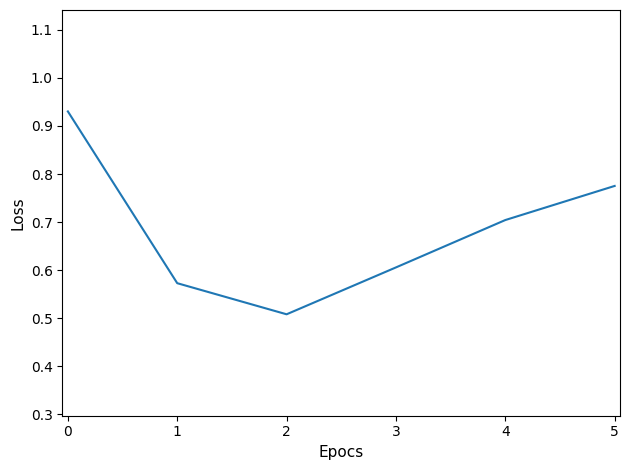

In [89]:
#Ploting loss
loss_file = open("old_tests/loss_8.txt", "r")
data = loss_file.read()
data_loss_list = data.split("\n")
loss_file.close()

data_loss_list = [i for i in data_loss_list if i]
data_loss = [float(i) for i in data_loss_list]

data_loss_mean = list()
for i in range(int(len(data_loss_list)/ 30)):
    data_loss_mean.append(mean(data_loss[i*30:(i*30)+30]))
    
plot_loss(data_loss_mean)

In [83]:
questions, answers = create_dataset(num_examples=None)

for i in range(5):
    index = random.randint(0,len(questions))
    result, _, prediction_percentages = response(questions[index])
    bleu = bleu_score(remove_tags(answers[index]), remove_tags(result))
    print('\n---------------')
    print('Question: ', remove_tags(questions[index]))
    print('Real awnser: ', remove_tags(answers[index]))
    print('Predicted awnser: ', remove_tags(result))
    print('BLEU Score: ', bleu)
    print('Precision: ', prediction_percentages)
    print('---------------')


---------------
Question:   what quote or scene would almost everyone know just by the first few words ?  
Real awnser:   to be , or not to be , that is the question .  
Predicted awnser:  what is this ? 
BLEU Score:  0.006432854093395396
---------------

---------------
Question:   if you could marry any television character , who would it be ?  
Real awnser:   echo from dollhouse aka eliza dushku 
Predicted awnser:  definitely classical , can literally also on sexual relations with a q 45 grey and threw themselves and honey until they fight me before the right now it's just a q hope i'm completely cold . 
BLEU Score:  0
---------------

---------------
Question:   what is the dumbest myth you ever heard ?  
Real awnser:   shaving makes hair grow back faster and more coarse .  
Predicted awnser:  not for the line who causes yo mama ? v 
BLEU Score:  0
---------------

---------------
Question:   what movie had such a good twist that it left you mind blown ?  
Real awnser:   saw got m

In [74]:
class Chatbot:
    negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
    exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
    min_precision = 6
    last_question = None
    
    def start_chat(self):
        user_response = input("Hi, I'm a chatbot trained on dialogs. Would you like to chat with me?\n")
    
        if user_response in self.negative_responses:
            print("Ok, have a great day!")
            return
        self.chat(user_response)
    
    def chat(self, sentence):
        while not self.make_exit(sentence):
            if self.last_question is not None:
                print("Learning ... ")
                self.retrain(sentence)
                self.last_question = None
                sentence = input("What more can I help you with?")
            else:
                sentence = input(self.generate_response(sentence))
  
    def generate_response(self, sentence):
        result, attention_plot, prediction_percentages = response(sentence)
        precision = prediction_precision(prediction_percentages)
        if precision < self.min_precision:
            self.last_question = sentence
            return "Sorry, I'm still learning, what could be a possible answer to this question?"
        else:
            return result
    
    def retrain(self, sentence):
        question = preprocess_sentence(self.last_question)
        answer = preprocess_sentence(sentence)
        
        questions_tensor = tokenize([question], tokenizer)
        answers_tensor = tokenize([answer], tokenizer)
        
        newdata = tf.data.Dataset.from_tensor_slices((questions_tensor, answers_tensor)).shuffle(BUFFER_SIZE)
        newdata = newdata.batch(BATCH_SIZE, drop_remainder=True)
    
        retrain_steps(newdata)
        return
        
        
    def make_exit(self, sentence):
        for exit_command in self.exit_commands:
            if exit_command in sentence:
                print("Ok, have a great day!")
                return True
        return False



In [75]:
chatbot = Chatbot()
chatbot.start_chat()

Hi, I'm a chatbot trained on dialogs. Would you like to chat with me?
what's the title of the current chapter of your life ? 
Sorry, I'm still learning, what could be a possible answer to this question?the great depression
Learning ... 
What more can I help you with?exit
Ok, have a great day!
